# Spesifikasi

- V<sub>in</sub> = 48V
- V<sub>out</sub> = 12V
- P<sub>o</sub> = 100W
- &#916;V<sub>o</sub> &#8804; 1%
- &#916;I<sub>L</sub> &#8804; 10%
- f<sub>sw</sub> = 20e3
- Mosfet: IRFB4310PbF, Infineon

# Plecs

In [5]:
import xmlrpc.client as xml
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
model = 'buck'
file_type = '.plecs'
V_in = 48
V_out = 12
f_sw = 20e3

In [7]:
plecs = xml.Server("http://localhost:1080/RPC2").plecs

In [8]:
plecs.load(r"E:\OneDrive - UGM 365\Mata Kuliah\Skripsi\Plecs\Python\buck\buck.plecs")

0

In [9]:
plecs.get(model+'/L1')

[['Name', 'L1'],
 ['Type', 'Inductor'],
 ['CommentStatus', 'Active'],
 ['L', '0.00054'],
 ['i_init', '0']]

In [10]:
plecs.get(model+'/C')

[['Name', 'C'],
 ['Type', 'Capacitor'],
 ['CommentStatus', 'Active'],
 ['C', '4.338e-05'],
 ['v_init', '0']]

In [11]:
plecs.get(model+'/Symmetrical PWM1')

[['Name', 'Symmetrical PWM1'],
 ['Type', 'Subsystem'],
 ['CommentStatus', 'Active'],
 ['sampling', 'Natural (carrier starts at center)'],
 ['fc', '20000.0'],
 ['carrier_phaseshift', '0'],
 ['carrier_limits', '[0 1]'],
 ['output_values', '[-1 1]']]

In [12]:
plecs.get(model+'/RL')

[['Name', 'RL'],
 ['Type', 'Resistor'],
 ['CommentStatus', 'Active'],
 ['R', '1e-3']]

In [13]:
RL = plecs.get(model+'/RL', 'R')

In [14]:
plecs.get(model+'/ESR')

[['Name', 'ESR'],
 ['Type', 'Resistor'],
 ['CommentStatus', 'Active'],
 ['R', '0.025681987128706025']]

In [15]:
plecs.get(model+'/ESL')

[['Name', 'ESL'],
 ['Type', 'Inductor'],
 ['CommentStatus', 'Active'],
 ['L', '5.839164571365709e-08'],
 ['i_init', '0']]

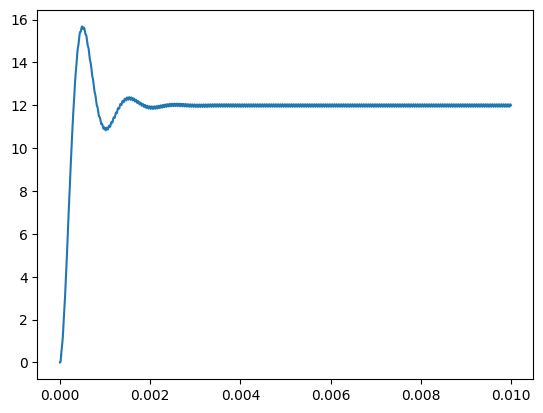

In [16]:
L = 540e-6
C = 43.38e-6
fsw = 20e3

plecs.set(model+'/L1','L', str(L))
plecs.set(model+'/C', 'C', str(C))
plecs.set(model+'/Symmetrical PWM1', 'fc', str(fsw))
times = plecs.simulate(model) ['Time']
current = plecs.simulate(model) ['Values'][0]
voltage = plecs.simulate(model) ['Values'][1]

plt.plot(times,voltage)

## Loop and save into CSV

In [21]:
import os
import csv

# Assuming you have a list of values for L, C, and fsw for each iteration
list_of_L_values = [540e-6, 600e-6, 700e-6]
list_of_C_values = [43.38e-6, 50e-6, 60e-6]
list_of_fsw_values = [20e3, 25e3, 30e3]

# Initialize the base directory for saving files
base_directory = 'simulation_results/'

# Create the base directory if it doesn't exist
os.makedirs(base_directory, exist_ok=True)

# Iterate over each set of values
for i in range(len(list_of_L_values)):
    L = list_of_L_values[i]
    C = list_of_C_values[i]
    fsw = list_of_fsw_values[i]

    # Set values in the PLECS model
    plecs.set(model+'/L1', 'L', str(L))
    plecs.set(model+'/C', 'C', str(C))
    plecs.set(model+'/Symmetrical PWM1', 'fc', str(fsw))

    # Simulate the PLECS model and obtain time, current, and voltage data
    times = plecs.simulate(model)['Time']
    current = plecs.simulate(model)['Values'][0]
    voltage = plecs.simulate(model)['Values'][1]

    # Create the CSV filename based on L, C, and fsw values
    csv_filename = os.path.join(base_directory, f'simulation_results_L_{L}_C_{C}_fsw_{fsw}.csv')

    # Write the time, voltage, and current to the CSV file
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Time', 'Voltage', 'Current'])
        for t, V, I in zip(times, voltage, current):
            csv_writer.writerow([t, V, I])


In [4]:
import itertools
import random
import numpy as np

# Given values
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
num_values = 20              # Number of values for each parameter

# Borders for R_L
border_values = [
    (144e-6, 0.079576),
    (509e-6, 0.179228),
    (1003e-6, 0.253239),
    (2519e-6, 0.443394)
]

# Constants for ESL calculation
K_esl = 4.389e-11  # Adjust as needed
tan_delta = 0.14

# Create arrays of discrete L, C, and fsw values within the specified ranges
L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)
fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values)

# Display the first 20 chosen values
print("First 20 chosen values:")
for _ in range(num_values):
    L = random.choice(L_values)
    C = random.choice(C_values)
    fsw = random.choice(fsw_values)
    print(f'L={L:.6f}, C={C:.6f}, fsw={fsw:.2f}')

# Generate all possible combinations
all_combinations = list(itertools.product(L_values, C_values, fsw_values))

# Display num_combinations combinations
num = 0
for combination in all_combinations:
    L, C, fsw = combination

    # Rules for picking R_L based on L
    R_L = next((rl for border, rl in border_values if L <= border), 0.0)

    # Calculate ESR and ESL based on the updated C
    ESR = tan_delta / (2 * np.pi * fsw * C)
    ESL = K_esl / C

    num += 1
    print(f'Combination {num}: L={L:.6f}, C={C:.6f}, fsw={fsw:.2f}, R_L={R_L:.6f}, ESR={ESR:.6f}, ESL={ESL:.6e}')


First 20 chosen values:
L=0.000548, C=0.000119, fsw=29473.68
L=0.001689, C=0.000075, fsw=105263.16
L=0.001585, C=0.000075, fsw=67368.42
L=0.000030, C=0.000128, fsw=38947.37
L=0.001793, C=0.000128, fsw=67368.42
L=0.001482, C=0.000084, fsw=57894.74
L=0.000756, C=0.000057, fsw=29473.68
L=0.001585, C=0.000075, fsw=86315.79
L=0.001585, C=0.000137, fsw=57894.74
L=0.001067, C=0.000066, fsw=38947.37
L=0.000445, C=0.000137, fsw=86315.79
L=0.000445, C=0.000084, fsw=114736.84
L=0.001274, C=0.000084, fsw=124210.53
L=0.001793, C=0.000066, fsw=86315.79
L=0.000134, C=0.000164, fsw=20000.00
L=0.000134, C=0.000111, fsw=29473.68
L=0.002000, C=0.000164, fsw=67368.42
L=0.000963, C=0.000200, fsw=57894.74
L=0.001793, C=0.000146, fsw=162105.26
L=0.001067, C=0.000200, fsw=143157.89
Combination 1: L=0.000030, C=0.000030, fsw=20000.00, R_L=0.079576, ESR=0.037136, ESL=1.463000e-06
Combination 2: L=0.000030, C=0.000030, fsw=29473.68, R_L=0.079576, ESR=0.025200, ESL=1.463000e-06
Combination 3: L=0.000030, C=0.0000

# &Delta; Current n Voltage

## Average Current

Average Current between 0.004 and 0.005 seconds: 2.382900080756942 A


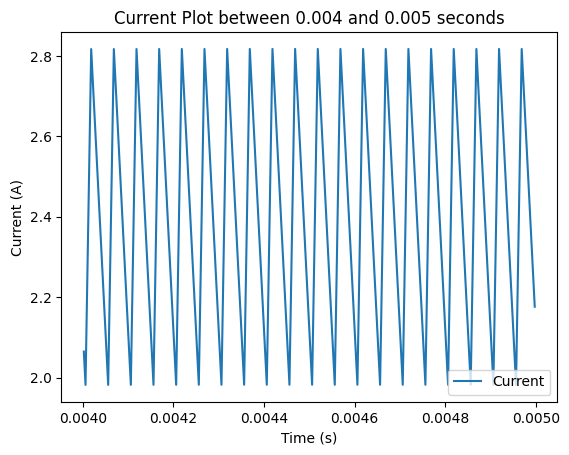

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'times' and 'current' are already defined

# Convert 'times' to a NumPy array
times = np.array(times)

# Find the indices corresponding to the time range
start_time = 0.004
end_time = 0.005

start_index = np.argmax(times >= start_time)
end_index = np.argmax(times >= end_time)

# Extract the current values in the specified time range
current_range = current[start_index:end_index]

# Calculate the average current value
average_current = np.mean(current_range)

print(f"Average Current between {start_time} and {end_time} seconds: {average_current} A")

# Plot only the current values in the specified time range
plt.plot(times[start_index:end_index], current_range, label='Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title(f'Current Plot between {start_time} and {end_time} seconds')
plt.legend()
plt.show()


## &Delta;I<sub>L</sub>%


Difference between highest and lowest current values between 0.004 and 0.005 seconds: 0.8350606168550487 A


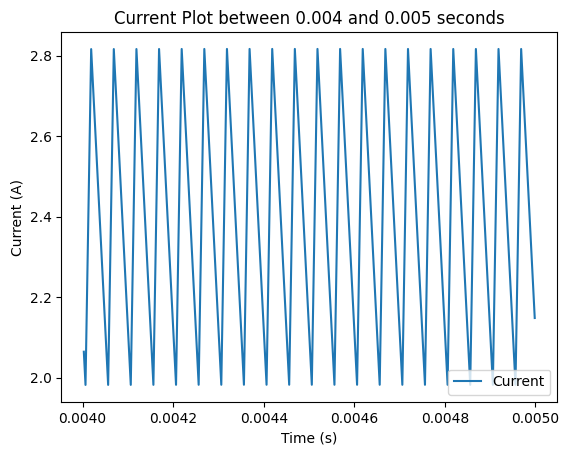

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'times' and 'current' are already defined

# Convert 'times' to a NumPy array
times = np.array(times)

# Find the indices corresponding to the time range
start_time = 0.004
end_time = 0.005

start_index = np.argmax(times >= start_time)
end_index = np.argmax(times >= end_time)

# Extract the current values in the specified time range
current_range = current[start_index:end_index]

# Calculate the difference between the highest and lowest current values
delta_current = np.max(current_range) - np.min(current_range)

print(f"Difference between highest and lowest current values between {start_time} and {end_time} seconds: {delta_current} A")

# Plot only the current values in the specified time range
plt.plot(times[start_index:end_index], current_range, label='Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title(f'Current Plot between {start_time} and {end_time} seconds')
plt.legend()
plt.show()


## &Delta;V<sub>O</sub>%


Difference between highest and lowest voltage values between 0.004 and 0.005 seconds: 0.11714774290565622 V


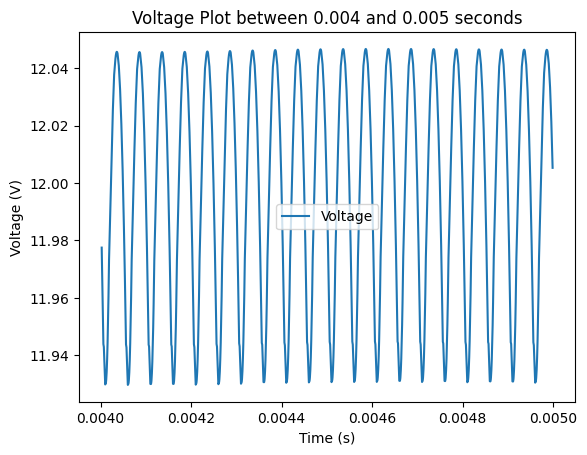

In [80]:
# Extract the current values in the specified time range
voltage_range = voltage[start_index:end_index]

# Calculate the difference between the highest and lowest current values
delta_voltage = np.max(voltage_range) - np.min(voltage_range)

print(f"Difference between highest and lowest voltage values between {start_time} and {end_time} seconds: {delta_voltage} V")

# Plot only the current values in the specified time range
plt.plot(times[start_index:end_index], voltage_range, label='Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title(f'Voltage Plot between {start_time} and {end_time} seconds')
plt.legend()
plt.show()


In [ ]:
# Get current values from the simulation
current = plecs.simulate(model)['Values'][0]

# Define the window size for the moving average
window_size = 100

# Calculate the moving average
moving_average = np.convolve(current, np.ones(window_size)/window_size, mode='valid')

# Plot the original and smoothed current values
plt.plot(times, current, label='Original Current')
plt.plot(times[:len(moving_average)], moving_average, label='Moving Average')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Current')
plt.legend()
plt.grid(True)
plt.title('Original and Smoothed Current')

# Show the plot
plt.show()

In [24]:
print(moving_average)

[2.02434026 2.06603734 2.10773442 ... 2.38625065 2.38819143 2.38957653]


# Losses

## Switching Losses

### Conduction Loss

- R<sub>DS(on)</sub> = R<sub>ON-H</sub> = R<sub>ON-L</sub> = 5.6k&Omega; 

#### High Side

P<sub>ON-H</sub> = I<sub>OUT</sub> / 2 &times; R<sub>ON-H</sub> &times; V<sub>OUT</sub> / V<sub>IN</sub> [W]


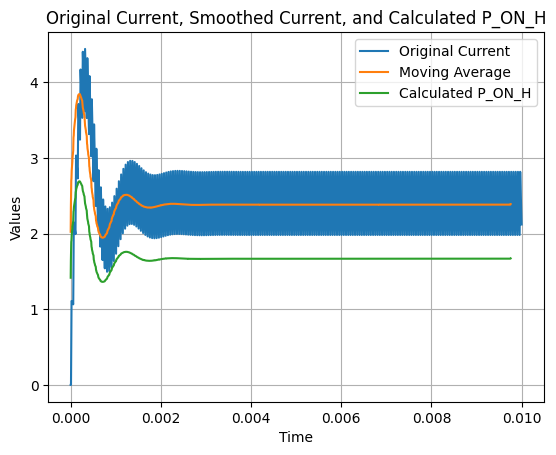

In [27]:
# Assuming you have R_ON_H, V_OUT, and V_IN defined
R_on = 5.6  # Replace with the actual value

# Calculate P_ON_H using the smoothed current values
P_ON_H = moving_average / 2 * R_on * V_out / V_in

# Plot the original and smoothed current values
plt.plot(times, current, label='Original Current')
plt.plot(times[:len(moving_average)], moving_average, label='Moving Average')

# Plot the calculated P_ON_H
plt.plot(times[:len(P_ON_H)], P_ON_H, label='Calculated P_ON_H')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.title('Original Current, Smoothed Current, and Calculated P_ON_H')

# Show the plot
plt.show()

In [47]:
# Assuming you have R_ON_H, V_OUT, and V_IN defined
R_on = 5.6  # Replace with the actual value

# Calculate P_ON_H using the smoothed current values
P_ON_H = average_current / 2 * R_on * V_out / V_in
print(P_ON_H)

1.6680300565298591


#### Low Side

P<sub>ON-L</sub> = I<sub>OUT</sub> / 2 &times; R<sub>ON-L</sub> &times; (1 - V<sub>OUT</sub> / V<sub>IN</sub>) [W]


In [ ]:
# Assuming you have R_ON_H, V_OUT, and V_IN defined
R_on = 5.6  # Replace with the actual value

# Calculate P_ON_L using the smoothed current values
P_ON_L = moving_average / 2 * R_on * V_out / V_in

# Plot the original and smoothed current values
plt.plot(times, current, label='Original Current')
plt.plot(times[:len(moving_average)], moving_average, label='Moving Average')

# Plot the calculated P_ON_L
plt.plot(times[:len(P_ON_L)], P_ON_L, label='Calculated P_ON_L')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.title('Original Current, Smoothed Current, and Calculated P_ON_L')

# Show the plot
plt.show()

In [46]:
# Assuming you have R_ON_H, V_OUT, and V_IN defined
R_on = 5.6  # Replace with the actual value

# Calculate P_ON_L using the smoothed current values
P_ON_L = average_current / 2 * R_on * V_out / V_in
print(P_ON_L)

1.6680300565298591


### Switching Losses

t<sub>rise</sub> = 110 ns  
t<sub>fall</sub> = 78 ns

#### High Side

P<sub>SW-H</sub> = 1/2 &times; V<sub>IN</sub> &times; I<sub>OUT</sub> &times; (t<sub>rise-H</sub> + t<sub>fall-H</sub>) &times; f<sub>SW</sub>


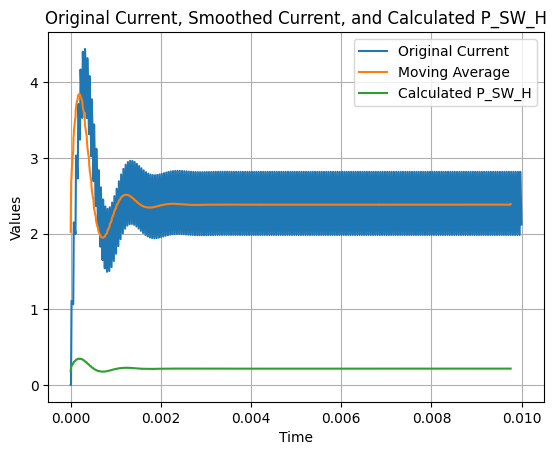

In [30]:
t_rise = 110e-9
t_fall = 78e-9

# Calculate P_SW_H
P_SW_H = 0.5 * V_in * moving_average * (t_rise + t_fall) * f_sw

# Plot the original and smoothed current values
plt.plot(times, current, label='Original Current')
plt.plot(times[:len(moving_average)], moving_average, label='Moving Average')

# Plot the calculated P_SW_H
plt.plot(times[:len(P_SW_H)], P_SW_H, label='Calculated P_SW_H')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.title('Original Current, Smoothed Current, and Calculated P_SW_H')

# Show the plot
plt.show()

In [49]:
t_rise = 110e-9
t_fall = 78e-9

# Calculate P_SW_H
P_SW_H = 0.5 * V_in * average_current * (t_rise + t_fall) * f_sw
print(P_SW_H)

0.2150329032875064


#### Low Side

P<sub>SW-L</sub> = 1/2 &times; V<sub>D</sub> &times; I<sub>OUT</sub> &times; (t<sub>rise-L</sub> + t<sub>fall-L</sub>) &times; f<sub>SW</sub>


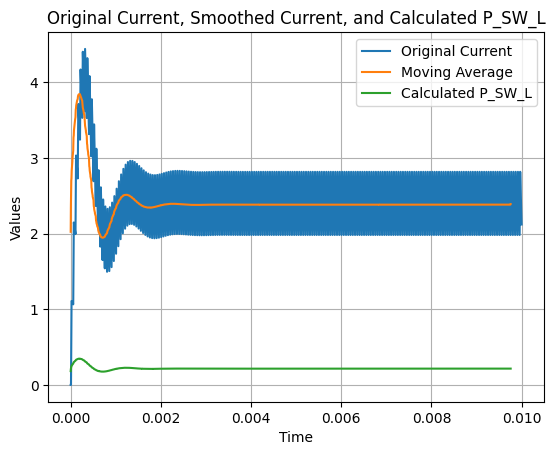

In [31]:
t_rise = 110e-9
t_fall = 78e-9

# Calculate P_SW_L
P_SW_L = 0.5 * V_in * moving_average * (t_rise + t_fall) * f_sw

# Plot the original and smoothed current values
plt.plot(times, current, label='Original Current')
plt.plot(times[:len(moving_average)], moving_average, label='Moving Average')

# Plot the calculated P_SW_L
plt.plot(times[:len(P_SW_L)], P_SW_L, label='Calculated P_SW_L')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.title('Original Current, Smoothed Current, and Calculated P_SW_L')

# Show the plot
plt.show()

In [50]:
t_rise = 110e-9
t_fall = 78e-9

# Calculate P_SW_L
P_SW_L = 0.5 * V_in * average_current * (t_rise + t_fall) * f_sw
print(P_SW_L)

0.2150329032875064
